In [2]:
from functions import *

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
import shutil
from matplotlib.colors import LogNorm

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load data

In [3]:
W = 256
source_path = '../data/raw/'
data_paths = ['lst', 'ndvi', 'wt']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {}
for i,dir_p in enumerate(dir_paths):
    all_dir_paths[data_paths[i]] = []
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p:
            all_dir_paths[data_paths[i]].append(subdir)
        #data, times = load_data(dir_paths,W,list_rgb)
all_dir_paths


{'lst': ['../data/raw/lst/Wasserfallenbach',
  '../data/raw/lst/Eibachli',
  '../data/raw/lst/Bisse-Neuf',
  '../data/raw/lst/LaVenoge_shapefile',
  '../data/raw/lst/le_boiron2',
  '../data/raw/lst/I_Custiell',
  '../data/raw/lst/La_Paudeze',
  '../data/raw/lst/Zauggenbach',
  '../data/raw/lst/Aletenbach',
  '../data/raw/lst/Alplibach',
  '../data/raw/lst/Plattenbach',
  '../data/raw/lst/swissTLMboiron',
  '../data/raw/lst/LaBroye_shapefile'],
 'ndvi': ['../data/raw/ndvi/Wasserfallenbach',
  '../data/raw/ndvi/Eibachli',
  '../data/raw/ndvi/Bisse-Neuf',
  '../data/raw/ndvi/LaVenoge_shapefile',
  '../data/raw/ndvi/le_boiron2',
  '../data/raw/ndvi/I_Custiell',
  '../data/raw/ndvi/La_Paudeze',
  '../data/raw/ndvi/Zauggenbach',
  '../data/raw/ndvi/Aletenbach',
  '../data/raw/ndvi/Alplibach',
  '../data/raw/ndvi/Plattenbach',
  '../data/raw/ndvi/swissTLMboiron',
  '../data/raw/ndvi/LaBroye_shapefile'],
 'wt': ['../data/raw/wt/Wasserfallenbach',
  '../data/raw/wt/Eibachli',
  '../data/raw/wt/

In [4]:
t=[]
total_data = {}
for k,v in all_dir_paths.items():
    if k == 'lst':
        list_rgb = [True]*len(v)
    else:
        list_rgb = [False]*len(v)
    data, times = load_data(v,W,list_rgb)
    
    #d = [item for sublist in data.values() for item in sublist]
    total_data[k] = np.concatenate(list(data.values()), axis=0)
    print(total_data[k].shape)
    t.append(times)

    

(1404, 256, 256, 3)


/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


(1404, 256, 256)
(1404, 256, 256)


In [5]:
lst = total_data['lst']
ndvi = total_data['ndvi']
data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (1404, 256, 256, 3) (1404, 256, 256)
targets shape: (1404, 256, 256)


In [6]:
gdf_points = gpd.read_file('../data/external/wt_filtered/wt_filtered.geojson')
times = gdf_points.time.dt.strftime("%Y-%m").unique()
months = gdf_points.time.dt.month.unique()

In [7]:
time_slots =np.tile(times, 13)
time_slots

array(['2011-01', '2011-02', '2011-03', ..., '2019-10', '2019-11',
       '2019-12'], dtype=object)

In [14]:
int(len(lst)/len(all_dir_paths['wt']))

108

# Delete unuseful data

In [136]:
'''new_inputs = []
new_targets = []
new_masked_inputs = []
del_indices = []
for index in range(0,lst.shape[0]):
  img_gray = np.dot(lst[index][...,:3], [0.2989, 0.5870, 0.1140])

  blacks = img_gray==0
  percentage_b = np.sum(blacks)/blacks.size * 100

  whites = img_gray>=240
  percentage_w = np.sum(whites)/whites.size * 100

  if not np.all(img_gray==255) and not np.all(img_gray==0) and not np.all(img_gray == img_gray[0,0]) and not (percentage_b > 50) and not (percentage_w > 50):
    new_inputs.append(lst[index])
    new_targets.append(data_targets[index])
    new_masked_inputs.append(masked_inputs[index])
  else:
    del_indices.append(index)

new_inputs = np.array(new_inputs)
new_targets = np.array(new_targets)
new_masked_inputs = np.array(new_masked_inputs)
slots = np.delete(time_slots,del_indices)'''

'new_inputs = []\nnew_targets = []\nnew_masked_inputs = []\ndel_indices = []\nfor index in range(0,lst.shape[0]):\n  img_gray = np.dot(lst[index][...,:3], [0.2989, 0.5870, 0.1140])\n\n  blacks = img_gray==0\n  percentage_b = np.sum(blacks)/blacks.size * 100\n\n  whites = img_gray>=240\n  percentage_w = np.sum(whites)/whites.size * 100\n\n  if not np.all(img_gray==255) and not np.all(img_gray==0) and not np.all(img_gray == img_gray[0,0]) and not (percentage_b > 50) and not (percentage_w > 50):\n    new_inputs.append(lst[index])\n    new_targets.append(data_targets[index])\n    new_masked_inputs.append(masked_inputs[index])\n  else:\n    del_indices.append(index)\n\nnew_inputs = np.array(new_inputs)\nnew_targets = np.array(new_targets)\nnew_masked_inputs = np.array(new_masked_inputs)\nslots = np.delete(time_slots,del_indices)'

Including NDVI data

In [ ]:
del_indices = []
fixed_ndvi = []
test_index = 0
for index in range(0,lst.shape[0]):
  # Obtain percentage of black and white pixels of lst
  img_gray = np.dot(lst[index][...,:3], [0.2989, 0.5870, 0.1140])
  blacks = img_gray==0
  percentage_b = np.sum(blacks)/blacks.size * 100
  whites = img_gray>=240
  percentage_w = np.sum(whites)/whites.size * 100

  # Obtain percentage of black and white pixels of ndvi
  img_ndvi = ndvi[index]
  whites = np.isnan(img_ndvi)
  percentage_w_ndvi = np.sum(whites)/whites.size * 100
  img_binned = (img_ndvi // 30) * 30  # Agrupar en múltiplos de 30
  # Obtener los valores únicos y sus frecuencias después del binning
  unique, counts = np.unique(img_binned, return_counts=True)
  # Crear un diccionario con los valores únicos (intensidades) y sus recuentos de píxeles
  pixel_frequencies = dict(zip(unique, counts))
  # Calcular el porcentaje para cada color
  total_pixels = img_ndvi.size  # Número total de píxeles
  max_percentage = max([count / total_pixels * 100 for count in pixel_frequencies.values()])  # Obtener el porcentaje máximo de cualquier color

  # Agregar la condición de que ningún color represente más del 50%
  if np.all(img_gray == 255) or np.all(img_gray == 0) or np.all(img_gray == img_gray[0, 0]) \
    or (percentage_b > 50) or (percentage_w > 50) or np.all(np.isnan(img_ndvi)) \
    or np.all(img_ndvi == img_ndvi[0, 0]) or (percentage_w_ndvi > 50):# \or max_percentage > 80:
    del_indices.append(index)
    plt.imshow(np.clip(lst[index]*(6/255),0,1))#, cmap='inferno', origin='lower',norm=LogNorm())
    plt.show()
    print()
  else:
    
    new_ndvi = np.where(whites, 0.0, img_ndvi) # process ndvi images to not have nans
    fixed_ndvi.append(new_ndvi)
    ndvi[index]= new_ndvi
    imgs_per_river = int(len(lst)/len(all_dir_paths['lst']))
    if index > imgs_per_river:
      test_index = index -imgs_per_river
    else:
      test_index = index
    print('Clean lst for,', time_slots[index])
    #print(np.unique(lst[index]))
    '''plt.imshow(np.clip(lst[index]*(6/255),0,1))#, cmap='inferno', origin='lower',norm=LogNorm())
    plt.show()
    print()'''

    '''
    plt.imshow(new_ndvi)
    plt.show()'''
  

In [23]:
fixed_ndvi = np.array(fixed_ndvi)

In [24]:
slots = np.delete(time_slots,del_indices)

In [25]:
len(slots)

119

# Mask Landsat data

In [ ]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = []
for raster in files:
    raster_path = os.path.join(dir_path, raster)
    rast,meta = load_raster(raster_path,False)
    river_masks.append(rast)
    plt.imshow(rast)
    plt.show()

In [ ]:
count = 0
masked_inputs = []
for river_mask in river_masks:
    print('Selected image shape:', river_mask.shape)
    for i in range(len(times)):
        river_mask_expanded = np.expand_dims(river_mask, axis=-1)  # Expande para tener forma (height, width, 1)
        river_mask_expanded = np.repeat(river_mask_expanded, lst.shape[-1], axis=-1)  # Expande a (height, width, 3)

        ind = i + count
        if ind not in del_indices:
            input_img = lst[ind]
            masked_input = input_img * river_mask_expanded  # Aplica la máscara a los inputs
            masked_inputs.append(masked_input)
            plt.imshow(masked_input)
            plt.show()
       
    count += len(times)

# Convierte  de nuevo a arrays de numpy
masked_inputs = np.array(masked_inputs)

# Verifica las formas
print('masked inputs shape:', masked_inputs.shape)
    

# Mask NDVI data

In [ ]:
count = 0
masked_inputs_ndvi = []
for river_mask in river_masks:
    for i in range(len(times)):
        ind = i + count
        if ind not in del_indices:
            input_img = ndvi[ind]
            masked_input = input_img * river_mask # Aplica la máscara a los inputs
            masked_inputs_ndvi.append(masked_input)
            plt.imshow(masked_input)
            plt.show()
       
    count += len(times)

# Convierte  de nuevo a arrays de numpy
masked_inputs_ndvi = np.array(masked_inputs_ndvi)

# Verifica las formas
print('masked inputs shape:', masked_inputs_ndvi.shape)
    

# Download preprocessed data

In [ ]:
import fiona
import geopandas as gpd
from shapely.geometry import shape

source_folder = '../data/external/shp/rivers/'
rivers = {}
for subdir, dirs, files in os.walk(source_folder):
    if len(dirs) == 0:
        with fiona.open(subdir, 'r') as src:
            # Extraer geometrías y atributos
            features = []
            for feature in src:
                geom = shape(feature['geometry'])  # Convertir la geometría a un objeto Shapely
                properties = feature['properties']  # Obtener los atributos
                properties['geometry'] = geom  # Añadir la geometría a los atributos
                features.append(properties)

            # Convertir la lista de características a un GeoDataFrame
            river = gpd.GeoDataFrame(features, crs="EPSG:2056")
            original_crs = river.crs
            river = river.to_crs("EPSG:4326")
            print(subdir)
            rivers[subdir.split('/')[-1]] = river
            print(river.shape)

Clean preprocessed directories

In [30]:
raw_data_path = '../data/raw/'
preprocessed_data_path = '../data/preprocessed/'

data = ['lst', 'ndvi', 'wt']#,'wt_interpolated', 'lst/masked']
for d in data:
  for r in rivers.keys():
    dest_dir = os.path.join(preprocessed_data_path, d+f'/{r}')#f'{d}/{r}')
    os.makedirs(dest_dir, exist_ok=True)
    clear_directory(dest_dir)
    if d == 'lst':
      dest_dir_m = os.path.join(dest_dir, 'masked')
      os.makedirs(dest_dir_m, exist_ok=True)
      clear_directory(dest_dir_m)

Copy preprocessed images

In [31]:
from collections import Counter
for d in data:
  source_dir = os.path.join(raw_data_path, d)
  dest_dir = os.path.join(preprocessed_data_path, d)

  # List all files in the source directory
  all_dirs = os.listdir(source_dir)
  count = 0
  included = 0
  imgs_per_river = Counter()

  # Loop through each file and check if it contains any of the slots
  for ind, (root, dirs, files) in enumerate(os.walk(source_dir)):
      if root != source_dir:
        river = rivers[root.split('/')[-1]]
        dest_dir_river = os.path.join(dest_dir, root.split('/')[-1])
        source_dir = root
        sorted_files = sorted(files, key=extract_year_month_from_filename)
        

        for file in sorted_files:
            if count not in del_indices:
                # Construct full file paths
                if d == 'ndvi':
                    date = file.split('_')[1].split('.')[0]
                    name = f'{dest_dir_river}/ndvi_{date}.tiff'
                    save_raster(fixed_ndvi[included], name, river)
                    print('Image', included)
                    print(f'Copied: ndvi_{date}, at {dest_dir_river}')
                else:
                    #dst_path = os.path.join(dest_dir, image_file)
                    dst_path = os.path.join(dest_dir_river, file)
                    src_path = os.path.join(source_dir, file)
                    # Copy the file to the destination folder
                    shutil.copy(src_path, dst_path)
                    print()
                    print('Image', included)
                    print(f'Copied: {file}, from {src_path}, to {dst_path}')

                    if d == 'lst':
                        date = file.split('_')[1].split('.')[0]
                        name = f'{dest_dir_river}/masked/lst_masked_{date}.tiff'
                        save_raster(masked_inputs[included], name, river)
                        print(f'Copied: lst_masked_{date}')
                included+=1
                imgs_per_river[root.split('/')[-1]] += 1
            count+=1





Image 0
Copied: image_2012-01.tiff, from ../data/raw/lst/Wasserfallenbach/image_2012-01.tiff, to ../data/preprocessed/lst/Wasserfallenbach/image_2012-01.tiff
Copied: lst_masked_2012-01

Image 1
Copied: image_2014-04.tiff, from ../data/raw/lst/Wasserfallenbach/image_2014-04.tiff, to ../data/preprocessed/lst/Wasserfallenbach/image_2014-04.tiff
Copied: lst_masked_2014-04

Image 2
Copied: image_2015-03.tiff, from ../data/raw/lst/Wasserfallenbach/image_2015-03.tiff, to ../data/preprocessed/lst/Wasserfallenbach/image_2015-03.tiff
Copied: lst_masked_2015-03

Image 3
Copied: image_2018-11.tiff, from ../data/raw/lst/Wasserfallenbach/image_2018-11.tiff, to ../data/preprocessed/lst/Wasserfallenbach/image_2018-11.tiff
Copied: lst_masked_2018-11

Image 4
Copied: image_2018-12.tiff, from ../data/raw/lst/Wasserfallenbach/image_2018-12.tiff, to ../data/preprocessed/lst/Wasserfallenbach/image_2018-12.tiff
Copied: lst_masked_2018-12

Image 5
Copied: image_2012-08.tiff, from ../data/raw/lst/Eibachli/ima

In [32]:
imgs_per_river

Counter({'Eibachli': 15,
         'LaBroye_shapefile': 14,
         'le_boiron2': 13,
         'La_Paudeze': 13,
         'swissTLMboiron': 13,
         'LaVenoge_shapefile': 12,
         'Alplibach': 10,
         'I_Custiell': 9,
         'Plattenbach': 8,
         'Wasserfallenbach': 5,
         'Bisse-Neuf': 3,
         'Zauggenbach': 3,
         'Aletenbach': 1})

CHECK

In [33]:
dir_paths = ['../data/preprocessed/ndvi/LaBroye_shapefile/']
W = 256
list_rgb = [False]
data, time_slots = load_data(dir_paths,W,list_rgb)

(14, 256, 256)
0


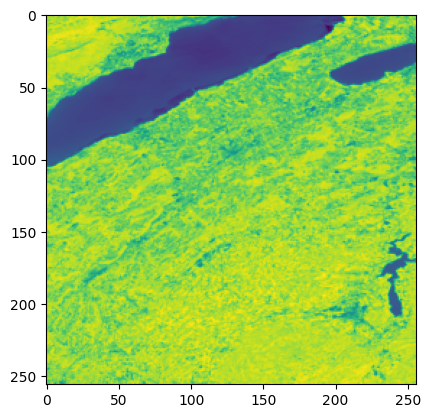

0


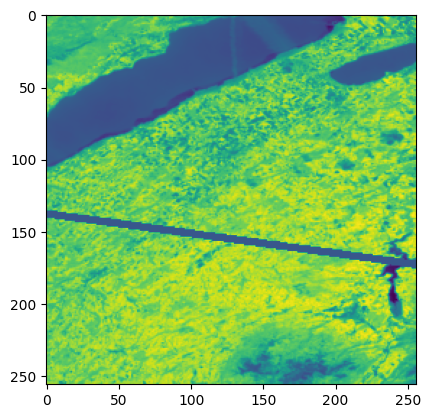

0


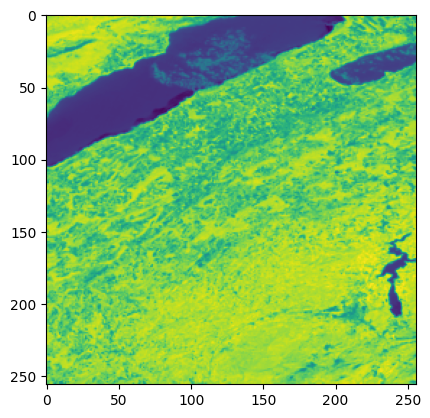

0


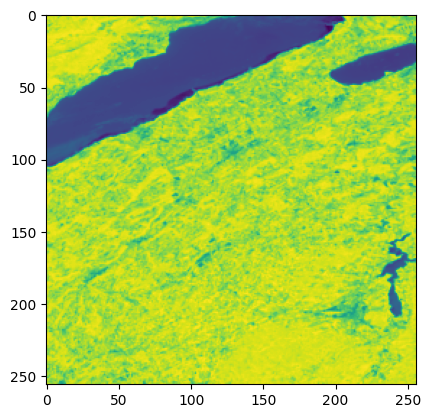

0


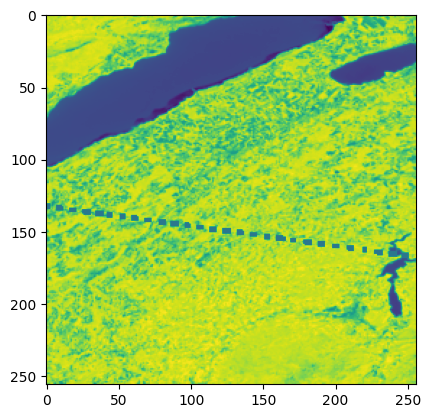

0


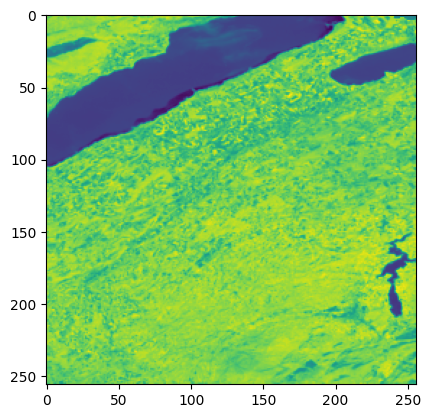

0


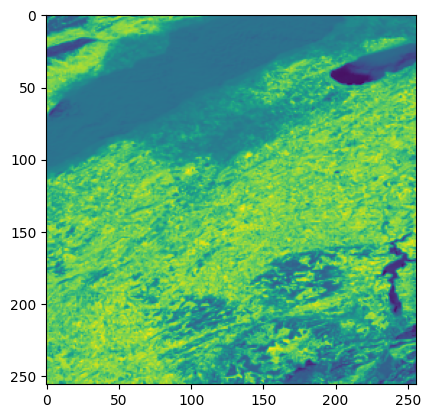

0


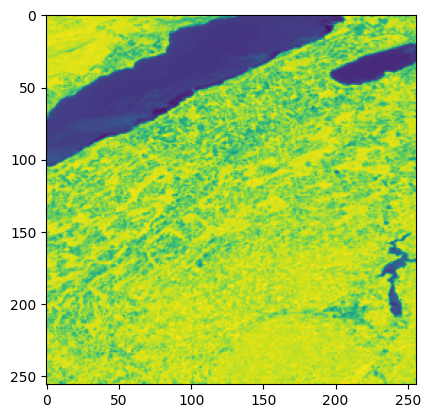

0


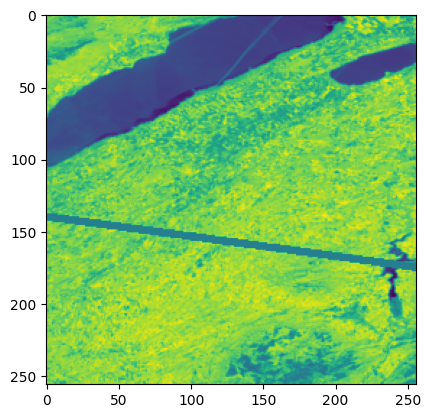

0


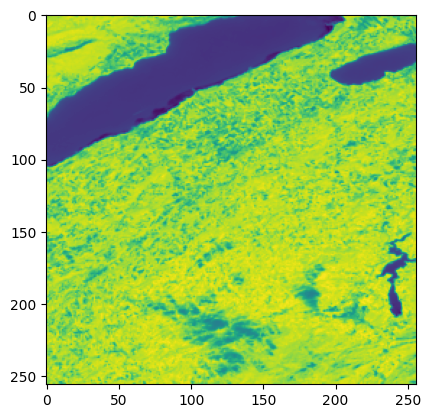

0


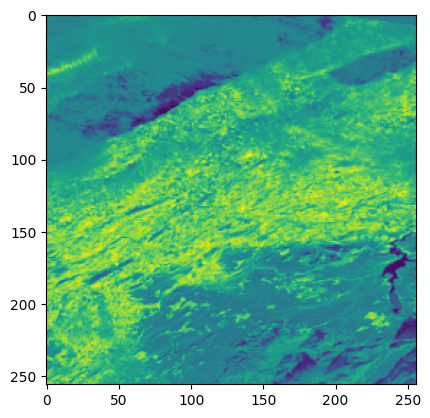

0


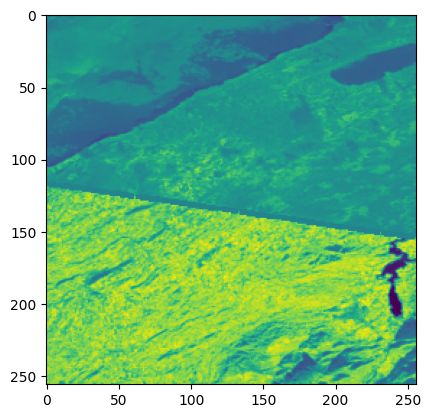

0


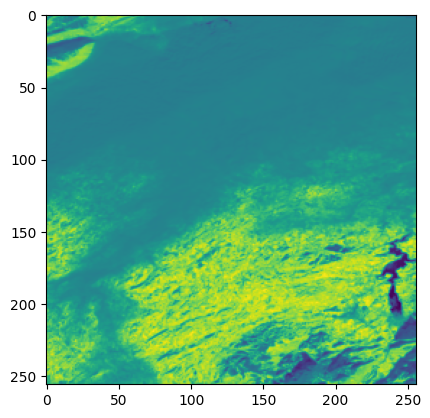

0


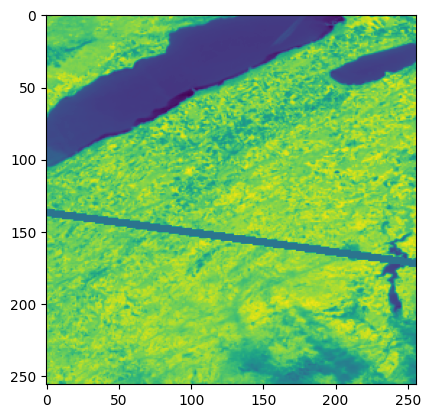

In [34]:
n = data[dir_paths[0]]
print(n.shape)
for i in n:
  print(np.sum(np.isnan(i)))
  plt.imshow(i)
  plt.show()

# Pixel wise dataset creation

In [35]:
river_indices = np.nonzero(river_mask.reshape(-1))[0]

In [36]:
len(river_indices)

719

### LST dataset

In [37]:
all_lst_ds = {}
last = 0
for i, (k,river) in enumerate(rivers.items()):
    river_mask = river_masks[i]
    river_indices = np.nonzero(river_mask.reshape(-1))[0]
    #print(river_indices.shape)
    pixel_ds_lst = pd.DataFrame(columns=[river_indices])
    
    for count in range(imgs_per_river[k]):
        ind = count + last
        image = masked_inputs[ind]
        img_gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
        flat_image = img_gray.flatten()
        river_image = flat_image[river_indices]
        pixel_ds_lst.loc[slots[ind]] = river_image
        
    last += imgs_per_river[k]    
    all_lst_ds[k] = pixel_ds_lst
    pixel_ds_lst.to_csv(f'../data/preprocessed/lst/{k}/{k}_lst.csv')
    

### NDVI dataset

In [38]:
all_ndvi_ds = {}
last = 0
for i, (k,river) in enumerate(rivers.items()):
    river_mask = river_masks[i]
    river_indices = np.nonzero(river_mask.reshape(-1))[0]
    #print(river_indices.shape)
    pixel_ds_ndvi = pd.DataFrame(columns=[river_indices])
    
    for count in range(imgs_per_river[k]):
        ind = count + last
        image = masked_inputs_ndvi[ind]
        flat_image = image.flatten()
        river_image = flat_image[river_indices]
        pixel_ds_ndvi.loc[slots[ind]] = river_image
        
    last += imgs_per_river[k]    
    all_ndvi_ds[k] = pixel_ds_ndvi
    pixel_ds_ndvi.to_csv(f'../data/preprocessed/ndvi/{k}/{k}_ndvi.csv')
    

### Water temperature dataset

In [39]:
all_wt_ds = {}
last = 0
for i, (k,river) in enumerate(rivers.items()):
    river_mask = river_masks[i]
    river_indices = np.nonzero(river_mask.reshape(-1))[0]
    #print(river_indices.shape)
    pixel_ds_wt = pd.DataFrame(columns=[river_indices])
    
    for count in range(imgs_per_river[k]):
        ind = count + last
        image = data_targets[ind]
        #img_gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
        flat_image = image.flatten()
        river_image = flat_image[river_indices]
        pixel_ds_wt.loc[slots[ind]] = river_image
        
    last += imgs_per_river[k]    
    all_wt_ds[k] = pixel_ds_wt
    pixel_ds_wt.to_csv(f'../data/preprocessed/wt/{k}/{k}_wt.csv')
    

### Water temperature stations dataset

In [40]:
pixel_ds_wt = pd.DataFrame(columns=[river_indices])
pixel_ds_wt

Empty DataFrame
Columns: [(185,), (186,), (443,), (444,), (701,), (702,), (959,), (960,), (961,), (1218,), (1219,), (1476,), (1477,), (1734,), (1735,), (1992,), (1993,), (1994,), (1995,), (2252,), (2253,), (2254,), (2255,), (2512,), (2513,), (2514,), (2515,), (2538,), (2539,), (2771,), (2772,), (2773,), (2791,), (2792,), (2793,), (2796,), (2797,), (2798,), (2799,), (3029,), (3030,), (3031,), (3032,), (3045,), (3046,), (3056,), (3288,), (3289,), (3290,), (3299,), (3300,), (3313,), (3314,), (3315,), (3316,), (3317,), (3547,), (3552,), (3553,), (3554,), (3574,), (3575,), (3576,), (3577,), (3804,), (3805,), (3806,), (3807,), (3834,), (4091,), (4348,), (4605,), (4862,), (5119,), (5375,), (5631,), (5887,), (6142,), (6397,), (6653,), (6907,), (6908,), (7160,), (7161,), (7162,), (7413,), (7414,), (7415,), (7666,), (7667,), (7668,), (7919,), (7920,), (7921,), (8173,), (8174,), (8426,), (8427,), (8428,), (8679,), ...]
Index: []

[0 rows x 719 columns]

In [41]:
c = 0
for i in range(len(wt_stations)):
  if times[3][i] in slots:
    image = wt_stations[i]
    flat_image = image.flatten()
    river_image = flat_image[river_indices]
    pixel_ds_wt.loc[slots[c]] = river_image
    c += 1

NameError: name 'wt_stations' is not defined

In [ ]:
pixel_ds_wt

29         30         31        285        286       287    \
2013-06  2.870015   9.654258   7.900476  3.759435   9.420562  4.067366   
2014-02  1.557188   5.236860   4.284557  2.040037   5.113762  2.208488   
2014-03  1.934015   6.504701   5.322274  2.533575   6.349988  2.742052   
2014-05  2.750221   9.250875   7.570085  3.602597   9.027983  3.898015   
2014-11  2.636063   8.865178   7.253474  3.453427   8.656421  3.738394   
2015-03  1.875099   6.305809   5.159029  2.456527   6.157527  2.659155   
2015-04  2.389212   8.035885   6.575341  3.129825   7.843899  3.386980   
2015-07  4.055289  13.642504  11.165133  5.311771  13.308857  5.745597   
2016-05  2.795304   9.402567   7.694179  3.661612   9.175463  3.961526   
2016-08  3.868896  13.014818  10.650978  5.067741  12.697994  5.482064   
2016-09  3.704787  12.462427  10.198731  4.852862  12.160157  5.250077   
2017-01  0.850973   2.858668   2.336710  1.115509   2.800255  1.210750   
2017-06  3.932402  13.228979  10.826443  5.150766  12.904815  5.570889   
2017-07  4.093045  13.769297  11.268651  5.361223  13.432455  5.798812   
2017-12  1.418495   4.769430   3.901542  1.858568   4.660367  2.013220   
2018-05  3.015616  10.144462   8.301918  3.950071   9.897760  4.273224   
2018-10  2.934588   9.870663   8.077229  3.844238   9.634620  4.160379   
2019-02  1.414088   4.754705   3.889360  1.852700   4.644657  2.006023   

            541        542       797        798    ...     65207     65208  \
2013-06  0.718058   9.883817  0.717980   7.738287  ...  6.145782  1.171358   
2014-02  0.390134   5.369808  0.390380   4.207460  ...  2.871255  0.547936   
2014-03  0.484265   6.665556  0.484426   5.221075  ...  3.708238  0.707442   
2014-05  0.688223   9.473084  0.688224   7.417587  ...  5.586770  1.065609   
2014-11  0.660332   9.088876  0.660687   7.120791  ...  4.881415  0.931167   
2015-03  0.469722   6.465285  0.470000   5.065597  ...  3.505339  0.668805   
2015-04  0.598097   8.232433  0.598221   6.447540  ...  4.752712  0.906617   
2015-07  1.014108  13.959079  1.013730  10.925843  ...  8.774162  1.673254   
2016-05  0.699396   9.626920  0.699353   7.537532  ...  5.639510  1.075492   
2016-08  0.967679  13.319910  0.967426  10.426780  ...  8.032539  1.531488   
2016-09  0.926800  12.757146  0.926641   9.987207  ...  7.566386  1.442626   
2017-01  0.214427   2.950813  0.215219   2.319600  ...  0.744969  0.142829   
2017-06  0.983222  13.533988  0.982804  10.592523  ...  8.359686  1.593963   
2017-07  1.023484  14.088153  1.023089  11.026713  ...  8.624727  1.644383   
2017-12  0.355829   4.897440  0.356280   3.839936  ...  2.298397  0.439130   
2018-05  0.754330  10.383171  0.754164   8.128275  ...  6.375079  1.215848   
2018-10  0.734658  10.112134  0.734792   7.919487  ...  5.702268  1.087672   
2019-02  0.354464   4.878743  0.354811   3.824101  ...  2.607499  0.497839   

            65209     65210     65461     65462     65463      65464  \
2013-06  0.000238  0.000225  0.000033  0.000169  1.545363   7.782999   
2014-02  0.000112  0.000106  0.000015  0.000079  0.722887   3.645128   
2014-03  0.000144  0.000136  0.000020  0.000102  0.933322   4.705002   
2014-05  0.000217  0.000206  0.000030  0.000153  1.405849   7.086148   
2014-11  0.000190  0.000180  0.000026  0.000134  1.228481   6.192655   
2015-03  0.000136  0.000129  0.000019  0.000096  0.882348   4.448438   
2015-04  0.000185  0.000175  0.000025  0.000130  1.196092   6.029368   
2015-07  0.000341  0.000323  0.000047  0.000240  2.207510  11.125372   
2016-05  0.000219  0.000207  0.000030  0.000155  1.418887   7.150568   
2016-08  0.000312  0.000295  0.000043  0.000220  2.020478  10.180165   
2016-09  0.000294  0.000278  0.000040  0.000207  1.903243   9.589507   
2017-01  0.000029  0.000028  0.000004  0.000020  0.188433   0.954024   
2017-06  0.000325  0.000307  0.000045  0.000229  2.102901  10.596308   
2017-07  0.000335  0.000317  0.000046  0.000236  2.169421  10.930642   
2017-12  0.000090  0.000085  0.000012  0.0

In [ ]:
pixel_ds_wt.to_csv('../data/preprocessed/wt_interpolated/leboiron_wt_interpolated.csv')